In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/CEA - CosmoStat/Week 4"
%cd /content/drive/My Drive/CEA - CosmoStat/Week 4

!apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
!pip install plotly tfa-nightly tqdm numpy matplotlib
!pip install rmjarvis.eigency>=1.77.1
!pip install scikit-image
!pip install tensorflow-addons

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'=1.77.1'   __pycache__   unet.py   unets_vertical.ipynb
/content/drive/My Drive/CEA - CosmoStat/Week 4
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libfftw3-dev is already the newest version (3.3.7-1).
python-dev is already the newest version (2.7.15~rc1-1).
libeigen3-dev is already the newest version (3.3.4-4).
pybind11-dev is already the newest version (2.0.1-4).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.restoration import estimate_sigma

from unet import Unet

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)

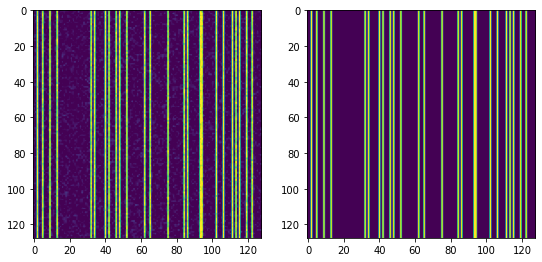

In [4]:
np.random.seed(seed=10)
noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 8
im_size = 128
prop_bands = 0.2
n_images = 15000
proportion_train_val = 0.8

new_vignets_noiseless = np.zeros((n_images,im_size,im_size))
new_vignets_with_noise = np.zeros((n_images,im_size,im_size))
std = np.zeros((n_images,1))

for it in range(n_images):
  im = np.zeros((im_size, im_size), dtype=np.float64)
  band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
  im[:, band_locations] = 1.0
  new_vignets_noiseless[it,:,:] = im

  if it > proportion_train_val*n_images:
      noise_std_range = (noise_std_val, noise_std_val)
  else: 
      noise_std_range = noise_std_train

  noise_std = tf.random.uniform(
      (1,),
      minval=noise_std_range[0],
      maxval=noise_std_range[1],
  )
  
  noise = tf.random.normal(shape=tf.shape(im), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
  std[it] = noise_std/255
  new_vignets_with_noise[it,:,:] = im+noise

fig, axs = plt.subplots(1, 2)

axs[0].imshow(np.squeeze(new_vignets_with_noise[10,:,:]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(new_vignets_noiseless[10,:,:]), vmin=0, vmax=1)

train_dic = {'VIGNET_NOISELESS':new_vignets_noiseless,'VIGNETS_WITH_NOISE':new_vignets_with_noise,  
             'TRUE_NOISE': std}

In [5]:
def keras_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1)

def keras_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1)

def center_keras_psnr(y_true, y_pred):
    return tf.image.psnr(_tf_crop(y_true, crop=128), _tf_crop(y_pred, crop=128), 1)

In [6]:
n_train = int(n_images*proportion_train_val)

im_train, im_val, target_train, target_val = train_test_split(train_dic['VIGNETS_WITH_NOISE'], train_dic['VIGNET_NOISELESS'], 
                                                              shuffle=False, stratify=None, test_size=1-proportion_train_val, random_state=10)
sigma = train_dic['TRUE_NOISE']
im_train, target_train, sigma[0:n_train] = shuffle(im_train, target_train, sigma[0:n_train])

im_train = (tf.reshape(tf.convert_to_tensor(im_train), [n_train, im_size, im_size, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [n_train, im_size, im_size, 1])
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [n_images-n_train, im_size, im_size, 1]))
target_val = tf.reshape(tf.convert_to_tensor(target_val), [n_images-n_train, im_size, im_size, 1])
sigma_train = tf.reshape(tf.convert_to_tensor(sigma[0:n_train]), [n_train, 1])
sigma_val = tf.reshape(tf.convert_to_tensor(sigma[n_train:n_images]), [n_images-n_train, 1])

model=Unet(n_output_channels=1, kernel_size=3, layers_n_channels=[4, 8, 16, 32])
n_epochs = 20

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=[keras_psnr, keras_ssim])


In [7]:
def estimated_std(img):
    return estimate_sigma(img, multichannel=False)

estimated_std_train = tf.reshape(tf.convert_to_tensor(np.array([estimated_std(im_train[i,:,:,0]) for i in np.arange(n_train)])), [n_train,1])
estimated_std_val = tf.reshape(tf.convert_to_tensor(np.array([estimated_std(im_val[i,:,:,0]) for i in np.arange(n_images-n_train)])), [n_images-n_train,1])

print(sigma_train)
print(estimated_std_train)
print(sigma_val)
print(estimated_std_val)

tf.Tensor(
[[0.19147339]
 [0.033623  ]
 [0.19151947]
 ...
 [0.03747036]
 [0.15974672]
 [0.14755885]], shape=(12000, 1), dtype=float64)
tf.Tensor(
[[0.19276376]
 [0.03252318]
 [0.19045642]
 ...
 [0.03806604]
 [0.15148606]
 [0.15010977]], shape=(12000, 1), dtype=float64)
tf.Tensor(
[[0.10999082]
 [0.11764706]
 [0.11764706]
 ...
 [0.11764706]
 [0.11764706]
 [0.11764706]], shape=(3000, 1), dtype=float64)
tf.Tensor(
[[0.10639885]
 [0.11600941]
 [0.11721624]
 ...
 [0.11399047]
 [0.11517171]
 [0.1165263 ]], shape=(3000, 1), dtype=float64)


Epoch 1/20
200/200 [==============================] - 37s 28ms/step - loss: 0.0108 - keras_psnr: 23.6863 - keras_ssim: 0.7832 - val_loss: 0.0027 - val_keras_psnr: 25.6579 - val_keras_ssim: 0.8561
Epoch 2/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0026 - keras_psnr: 27.8496 - keras_ssim: 0.8662 - val_loss: 0.0018 - val_keras_psnr: 27.5545 - val_keras_ssim: 0.9022
Epoch 3/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0021 - keras_psnr: 28.8954 - keras_ssim: 0.8794 - val_loss: 0.0017 - val_keras_psnr: 27.5934 - val_keras_ssim: 0.8971
Epoch 4/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0019 - keras_psnr: 28.9741 - keras_ssim: 0.8942 - val_loss: 0.0015 - val_keras_psnr: 28.3046 - val_keras_ssim: 0.9001
Epoch 5/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0018 - keras_psnr: 29.1107 - keras_ssim: 0.8947 - val_loss: 0.0014 - val_keras_psnr: 28.5473 - val_keras_ssim: 0.9142
Epoch 6/20
200/200 [====

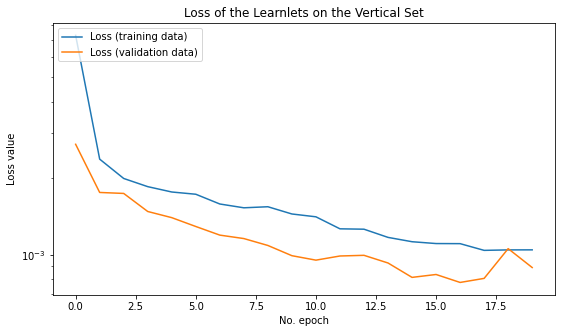

In [8]:
history = model.fit((im_train, estimated_std_train), target_train, steps_per_epoch=200, epochs=n_epochs, validation_data=((im_val, estimated_std_val), target_val), batch_size=batch_size)

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss of the Learnlets on the Vertical Set')
plt.ylabel('Loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Model: "unet"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
conv_block (ConvBlock)                                multiple                                        188               
________________________________________________________________________________________________________________________
conv_block_1 (ConvBlock)                              multiple                                        880               
________________________________________________________________________________________________________________________
conv_block_2 (ConvBlock)                              multiple                                        3488              
________________________________________________________________________________________________________________________
max_pooling2d (Max

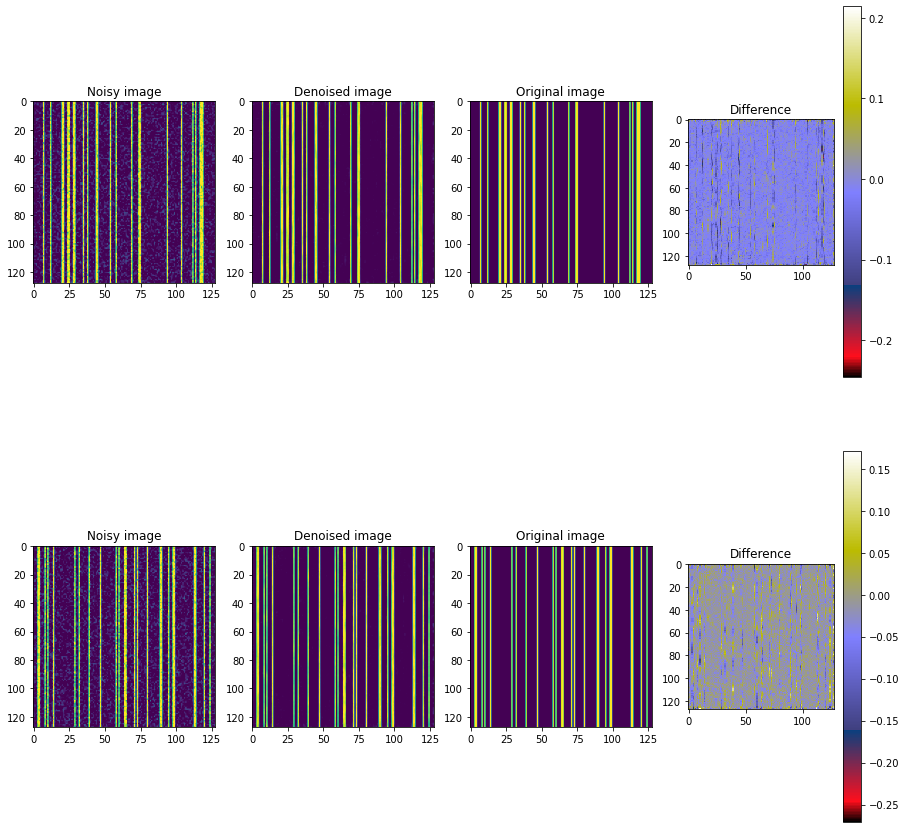

In [9]:
print(model.summary(line_length=120))

one_vertical_noiseless = tf.reshape(model.predict((im_val, estimated_std_val))[179,:,:], [im_size, im_size])
one_vertical_truth = tf.reshape(tf.convert_to_tensor(target_val[179,:,:]), [im_size, im_size])
one_vertical_noiseless = tf.cast(one_vertical_noiseless, one_vertical_truth.dtype)
one_vertical_noise = tf.reshape(tf.convert_to_tensor(im_val[179,:,:]), [im_size, im_size])
second_vertical_noiseless = tf.reshape(model.predict((im_val, estimated_std_val))[181,:,:], [im_size, im_size])
second_vertical_truth = tf.reshape(tf.convert_to_tensor(target_val[181,:,:]), [im_size, im_size])
second_vertical_noiseless = tf.cast(second_vertical_noiseless, second_vertical_truth.dtype)
second_vertical_noise = tf.reshape(tf.convert_to_tensor(im_val[181,:,:]), [im_size, im_size])



fig = plt.figure(num=0, figsize=(15,15))
plt.subplot(241)
plt.title('Noisy image')
plt.imshow(one_vertical_noise, vmin=0, vmax=1);
plt.subplot(242)
plt.imshow(one_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(243)
plt.title('Original image')
plt.imshow(one_vertical_truth, vmin=0, vmax=1);
plt.subplot(244)
plt.title('Difference')
plt.imshow(one_vertical_noiseless-one_vertical_truth, interpolation='None',cmap='gist_stern');plt.colorbar()
plt.subplot(245)
plt.title('Noisy image')
plt.imshow(second_vertical_noise, vmin=0, vmax=1);
plt.subplot(246)
plt.imshow(second_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(247)
plt.title('Original image')
plt.imshow(second_vertical_truth, vmin=0, vmax=1);
plt.subplot(248)
plt.title('Difference')
plt.imshow(second_vertical_noiseless-second_vertical_truth, interpolation='None',cmap='gist_stern');plt.colorbar()
plt.show()

In [10]:
metrics = model.evaluate((im_train, sigma_train), target_train, steps=300)

300/300 [==============================] - 5s 13ms/step - loss: 0.0011 - keras_psnr: 31.0561 - keras_ssim: 0.8511
